# Cartographie des peuplements et NDVI
## Librairies

In [540]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster, GroupedLayerControl
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from matplotlib.colors import Normalize
import seaborn as sns
import matplotlib.pyplot as plt


directory = os.getcwd()

## Importations et pre-processing

In [541]:
# Importation données de peuplement
data1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx")
data1 = data1.loc[:,["parcelle","date","latitude_GPS", "longitude_GPS", "peuplement"]]

data2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx")
data2 = data2.loc[:,["numero_parcelle","date_obs","latitude_GPS", "longitude_GPS", "peuplement"]]
data2.rename(columns={'numero_parcelle': 'parcelle',
                   'date_obs': 'date',
                   'latitude_GPS': 'latitude_GPS',
                   'longitude_GPS': 'longitude_GPS',
                   'peuplement': 'peuplement'}, inplace = True)

data3 = pd.read_csv(f"{directory}/donnees/peuplement/comptages_yonne_2022.csv", sep = ";", parse_dates = ["date"], dayfirst = True)
data3 = data3.loc[:,["id_parcelle","date","latitude","longitude", "peuplement"]]
data3.rename(columns={'id_parcelle': 'parcelle',
                   'date': 'date',
                   'latitude': 'latitude_GPS',
                   'longitude': 'longitude_GPS',
                   'peuplement': 'peuplement'}, inplace = True)
data3["latitude_GPS"] = data3["latitude_GPS"].str.replace(",", ".")
data3["longitude_GPS"] = data3["longitude_GPS"].str.replace(",", ".")
data3["peuplement"] = data3["peuplement"].str.replace(",", ".")

donnees_ppm = pd.concat([data1, data2, data3])
donnees_ppm.dropna(subset=['latitude_GPS', 'longitude_GPS', 'peuplement'], inplace = True)

donnees_ppm["parcelle"] = donnees_ppm['parcelle'].astype(str)
donnees_ppm["latitude_GPS"] = donnees_ppm['latitude_GPS'].astype(float)
donnees_ppm["longitude_GPS"] = donnees_ppm['longitude_GPS'].astype(float)
donnees_ppm["peuplement"] = donnees_ppm['peuplement'].astype(float)

donnees_ppm['parcelle'] = donnees_ppm['parcelle'].astype('string')
donnees_ppm["parcelle"] = donnees_ppm["parcelle"].map(lambda x:x.replace('_','').lower())

In [542]:
print(donnees_ppm)

      parcelle       date  latitude_GPS  longitude_GPS  peuplement
0    tiravard1 2022-04-28     46.249431      -0.641666     31000.0
1    tiravard1 2022-04-28     46.249444      -0.641389     35000.0
2    tiravard1 2022-04-28     46.249722      -0.641578     42000.0
3    tiravard1 2022-04-28     46.249875      -0.641711     34000.0
4    tiravard1 2022-04-28     46.250031      -0.641666     35000.0
..         ...        ...           ...            ...         ...
109         20 2020-06-07     47.665270       3.470940     54000.0
110         20 2020-06-07     47.666060       3.471180     54000.0
111         20 2020-06-07     47.666810       3.471520     58000.0
112         20 2020-06-07     47.667770       3.471670     58000.0
113         20 2020-06-07     47.668330       3.472100     32000.0

[546 rows x 5 columns]


In [543]:
# Importation données NDVI
donnees_ndvi = pd.read_csv(f"{directory}/donnees/resultats_new.csv", sep = ";", parse_dates = ["date"], dayfirst = True)
donnees_ndvi = donnees_ndvi.loc[:,["parcelle","date","NDVI_moy"]]

donnees_ndvi['parcelle'] = donnees_ndvi['parcelle'].astype('string')
donnees_ndvi["parcelle"] = donnees_ndvi["parcelle"].map(lambda x:x.replace('_','').lower())

donnees_ndvi.columns = donnees_ndvi.columns.str.replace('NDVI_moy', 'ndvi_moy')

donnees_ndvi["annee"] = donnees_ndvi["date"].dt.year # on utilise cette colonne annee pour les jointures pr récup le peuplement et le précédent
donnees_ndvi["annee"] = donnees_ndvi["annee"].astype('string')
donnees_ndvi = donnees_ndvi.loc[:,["parcelle","ndvi_moy", "annee"]]

In [544]:
print(donnees_ndvi)

         parcelle  ndvi_moy annee
0        aubiet11      1616  2022
1        aubiet11      1765  2022
2        aubiet11      2428  2022
3        aubiet11      1998  2022
4        aubiet11      1692  2022
...           ...       ...   ...
1435  209gers2020      5720  2020
1436  209gers2020      5398  2020
1437  209gers2020      5589  2020
1438  209gers2020      5652  2020
1439  209gers2020      5812  2020

[1440 rows x 3 columns]


In [545]:
# Regroupement peuplement par parcelle
donnees_ppm_groupees = donnees_ppm.groupby("parcelle").agg(
    {
        "date": "first",
        "latitude_GPS": "mean",
        "longitude_GPS": "mean",
        "peuplement": "mean"
    }
)

# reset l'index pour avoir un dataframe en colonne et non en index
donnees_ppm_groupees = donnees_ppm_groupees.reset_index()

In [546]:
print(donnees_ppm_groupees)

       parcelle       date  latitude_GPS  longitude_GPS    peuplement
0          0222 2022-05-17     48.082200       2.300080  70400.000000
1          0522 2022-05-17     48.090820       2.281600  64800.000000
2          0622 2022-05-17     48.081940       2.274540  52800.000000
3             1 2020-05-16     47.628226       3.486882  43555.555556
4            10 2020-05-17     47.705306       3.465002  28800.000000
..          ...        ...           ...            ...           ...
90  tirosieres4 2022-05-16     48.788845       6.018055  41200.000000
91   tivillers5 2022-05-09     48.819288       6.007271  79600.000000
92   tivillers6 2022-05-09     48.818028       6.007171  72000.000000
93   tivillers7 2022-05-09     48.816633       6.001049  94000.000000
94   tivillers8 2022-05-09     48.819315       6.000279  82000.000000

[95 rows x 5 columns]


In [547]:
# Regroupement NDVI par parcelle
donnees_ndvi_groupees = donnees_ndvi.groupby("parcelle").agg(
    {
        "annee": "first",
        "ndvi_moy": "mean",
    }
)

# Reset l'index pour avoir un dataframe en colonne et non en index
donnees_ndvi_groupees = donnees_ndvi_groupees.reset_index()

# Remove
donnees_ndvi_groupees = donnees_ndvi_groupees[donnees_ndvi_groupees['parcelle'].isin(donnees_ppm_groupees['parcelle'])]

# Merge
donnees_ndvi_groupees = donnees_ndvi_groupees.merge(donnees_ppm_groupees[['parcelle', 'latitude_GPS', 'longitude_GPS']], on='parcelle')

In [548]:
print(donnees_ndvi_groupees)

        parcelle annee     ndvi_moy  latitude_GPS  longitude_GPS
0           0222  2022  4592.625000     48.082200       2.300080
1           0522  2022  6461.333333     48.090820       2.281600
2           0622  2022  5339.800000     48.081940       2.274540
3           1722  2022  5518.000000     48.068150       2.353575
4           2822  2022  4873.666667     48.181345       2.483060
5           2922  2022  4367.100000     48.182662       2.485827
6           3822  2022  5346.100000     48.079674       2.348550
7           4222  2022  4905.818182     48.076626       2.289709
8           4422  2022  5758.800000     48.061970       2.355677
9           4522  2022  4350.700000     48.046093       2.359616
10          4722  2022  5223.700000     48.044558       2.361880
11          5222  2022  4809.900000     48.057543       2.350939
12          5322  2022  7281.937500     48.201633       2.035381
13          5422  2022  5699.636364     48.136880       2.278060
14          6222  2022  4

## Création de la carte

In [549]:
# Initialiser une carte de France centrée sur les coordonnées (46.2276, 2.2137)
carte = folium.Map(location=[46.2276, 2.2137], zoom_start=6)

# Initialiser un cluster de marqueurs
vec_marker = MarkerCluster()
marqueurs = vec_marker.add_to(carte)

# Définition des couches pour les données de peuplement et de NDVI
peuplement_layer = folium.FeatureGroup(name='Peuplement')
ndvi_layer = folium.FeatureGroup(name='NDVI')

### Couche des peuplements

In [550]:
def regrouper_en_regions(donnees, nb_regions):
    kmeans = KMeans(n_clusters=nb_regions)
    kmeans.fit(donnees[["latitude_GPS", "longitude_GPS"]])
    donnees["region"] = kmeans.predict(donnees[["latitude_GPS", "longitude_GPS"]])
    return donnees, kmeans.cluster_centers_

In [551]:
donnees_ppm_groupees, centres = regrouper_en_regions(donnees_ppm_groupees, 5)

In [552]:
peuplement_moyen_par_region = donnees_ppm_groupees.groupby("region")["peuplement"].mean().reset_index()
print(peuplement_moyen_par_region)

   region    peuplement
0       0  51223.400409
1       1  60777.777778
2       2  36498.511905
3       3  46042.568543
4       4  32623.746299


In [553]:
# Définir la palette de couleurs en fonction du peuplement moyen
peuplement_min = peuplement_moyen_par_region['peuplement'].min()
peuplement_max = peuplement_moyen_par_region['peuplement'].max()
norm = colors.Normalize(vmin=peuplement_min, vmax=peuplement_max)
mapper = cm.ScalarMappable(norm=norm, cmap='Blues')

In [554]:
for region, peuplement in zip(peuplement_moyen_par_region["region"], peuplement_moyen_par_region["peuplement"]):
	color = mapper.to_rgba(peuplement)
	folium.Circle(
		location=centres[region],
		radius=peuplement*1.3,
		popup=f"Région: {region} \nPeuplement moyen: {peuplement}",
		color=color,
		fill=True,
		fill_color=color
	).add_to(peuplement_layer)

In [555]:
# Ajout marqueurs parcelles avec valeurs de peuplement
for nom, date, lat, lon, peuplement in zip(donnees_ppm_groupees["parcelle"], donnees_ppm_groupees["date"], donnees_ppm_groupees["latitude_GPS"], donnees_ppm_groupees["longitude_GPS"], donnees_ppm_groupees["peuplement"]):
    folium.CircleMarker(
        location=[lat, lon],
        radius= int(peuplement) / 3000,
        popup=f"Parcelle: {nom} \nPeuplement: {peuplement} \nDate: {date}",
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(peuplement_layer)

### Couche des NDVI

In [556]:
donnees_ndvi_groupees = donnees_ndvi_groupees.merge(donnees_ppm_groupees[['parcelle', 'region']], on='parcelle')

In [557]:
ndvi_moyen_par_region = donnees_ndvi_groupees.groupby("region")["ndvi_moy"].mean().reset_index()
print(ndvi_moyen_par_region)

   region     ndvi_moy
0       0  4934.677937
1       1  3709.352980
2       2  4207.569769
3       3  4718.363095


In [558]:
# Définir la palette de couleurs en fonction du peuplement moyen
ndvi_min = ndvi_moyen_par_region['ndvi_moy'].min()
ndvi_max = ndvi_moyen_par_region['ndvi_moy'].max()
norm1 = colors.Normalize(vmin=ndvi_min, vmax=ndvi_max)
mapper1 = cm.ScalarMappable(norm=norm1, cmap='Blues')

In [559]:
for region, ndvi in zip(ndvi_moyen_par_region["region"], ndvi_moyen_par_region["ndvi_moy"]):
	color = mapper1.to_rgba(ndvi)
	folium.Circle(
		location=centres[region],
		radius=ndvi*15,
		popup=f"Région: {region}\n NDVI moyen: {ndvi}",
		color=color,
		fill=True,
		fill_color=color
	).add_to(ndvi_layer)

In [560]:
# Ajout marqueurs parcelles avec valeurs de NDVI
for nom, date, ndvi, lat, lon in zip(donnees_ndvi_groupees["parcelle"], donnees_ndvi_groupees["annee"], donnees_ndvi_groupees["ndvi_moy"], donnees_ndvi_groupees["latitude_GPS"], donnees_ndvi_groupees["longitude_GPS"]):
    folium.CircleMarker(
        location=[lat, lon],
        radius= int(ndvi) / 200,
        popup=f"Parcelle: {nom} \nNDVI: {ndvi} \nAnnee: {date}",
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(ndvi_layer)

### Géneration de la carte

In [561]:
peuplement_layer.add_to(carte)
ndvi_layer.add_to(carte)

In [562]:
grouped_layers = {
"Couche": [peuplement_layer, ndvi_layer]
}

GroupedLayerControl(name='Couches', groups=grouped_layers).add_to(carte)

In [563]:
# Enregistrer la carte dans un fichier HTML
i = 1
while os.path.exists(f"{directory}/carte{i}.html"):
    i += 1
carte.save(f"carte{i}.html")

## Analyses statistiques

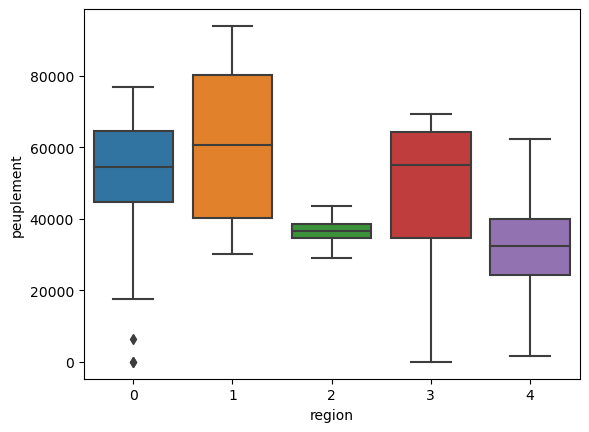

In [564]:
#Boxplot peuplement

sns.boxplot(x='region', y='peuplement', data=donnees_ppm_groupees)
plt.show()

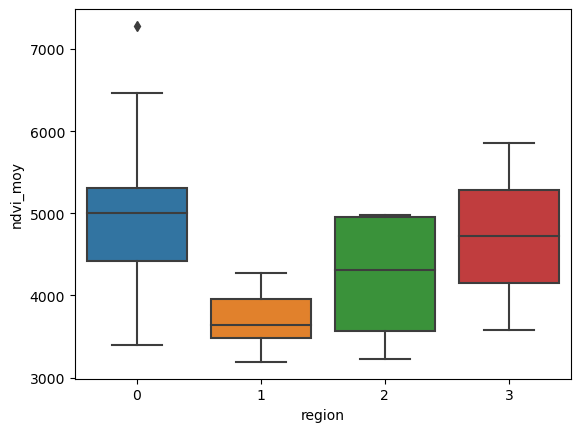

In [565]:
#Boxplot NDVI

sns.boxplot(x='region', y='ndvi_moy', data=donnees_ndvi_groupees)
plt.show()